# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/supervised_classification.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
import os
os.chdir("/Users/rabinatwayana/Rabina/CDE II/application development/nickyspatial/")
os.getcwd()


'/Users/rabinatwayana/Rabina/CDE II/application development/nickyspatial'

In [2]:
# ! pip install nickyspatial
! pip install -e .

Obtaining file:///Users/rabinatwayana/Rabina/CDE%20II/application%20development/nickyspatial
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for nickyspatial (pyproject.toml) ... done
  Created wheel for nickyspatial: filename=nickyspatial-0.0.9-py3-none-any.whl size=3874 sha256=9a13d0bdc2c888a2de4935a69a7812535caf3615df2d265109d078cf5ab19c38
  Stored in directory: /private/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/pip-ephem-wheel-cache-djq4fidg/wheels/ff/a4/71/995169819edad3ac72c34e6cdcd63f146bdb4339707ae509a5
Successfully built nickyspatial
  Attempting uninstall: nickyspatial
    Found existing installation: nickyspatial 0.0.9
    Uninstalling nickyspatial-0.0.9:
      Successfully uninstalled nickyspatial-0.0.9

[notice] A new release of pip is available: 2

In [3]:
import os
import requests
import matplotlib.pyplot as plt

from nickyspatial import (
    LayerManager,
    MultiResolutionSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_layer,
    plot_layer_interactive,
    read_raster,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassifier
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "Artifical_landscape_UTM_012025.tif")

if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/Artifical_landscape_UTM_012025.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [4]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (4, 877, 1164)
Coordinate system: EPSG:32654


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [5]:
manager = LayerManager()

segmenter = MultiResolutionSegmentation(scale=40, compactness=0.5)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 638
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 635)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

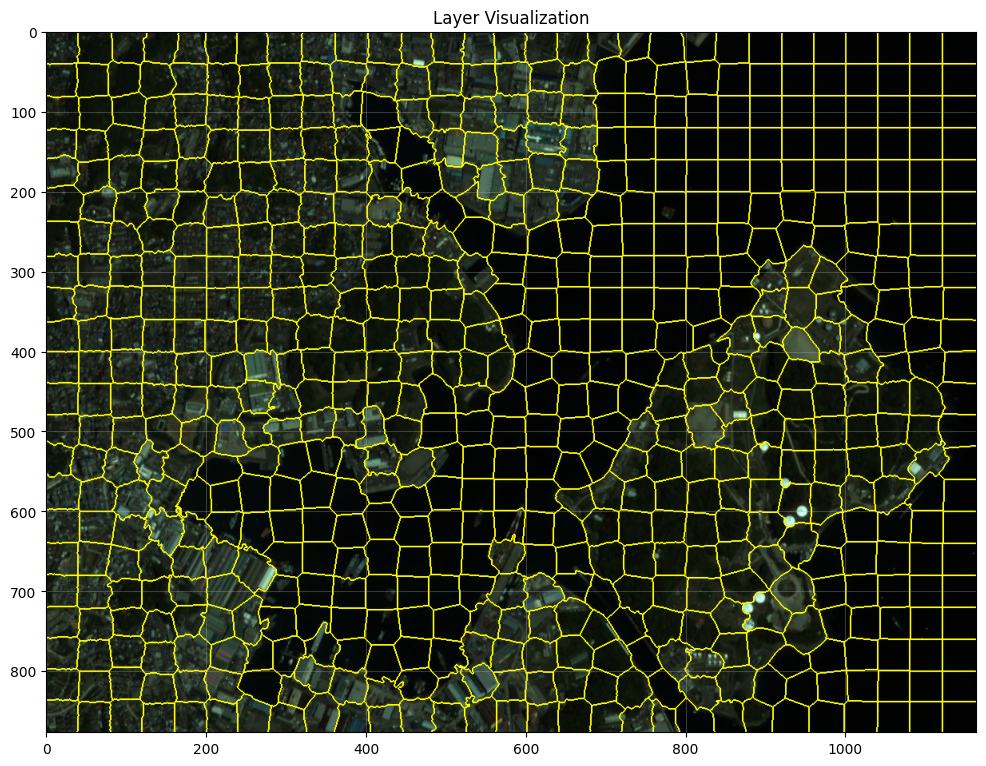

In [6]:
fig1 = plot_layer(layer=segmentation_layer, image_data=image_data, rgb_bands=(2, 1, 0), show_boundaries=True)
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

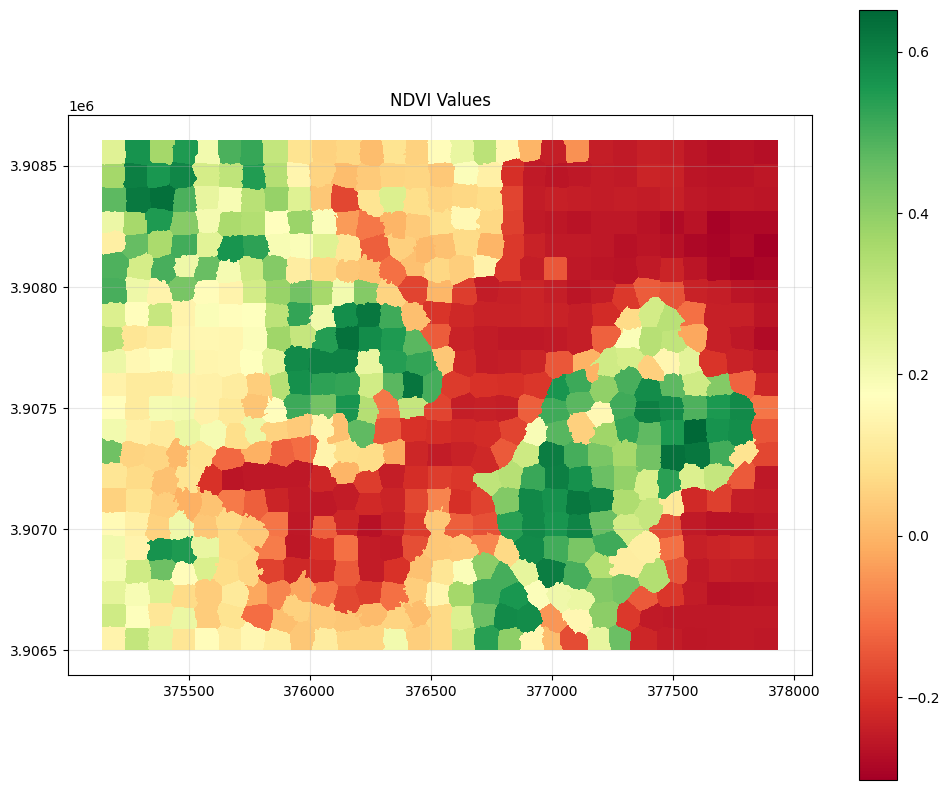

In [7]:
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")

fig2 = plot_layer(segmentation_layer, attribute="NDVI", title="NDVI Values", cmap="RdYlGn")
plt.show()

## Sample data collection

Output()

Output()

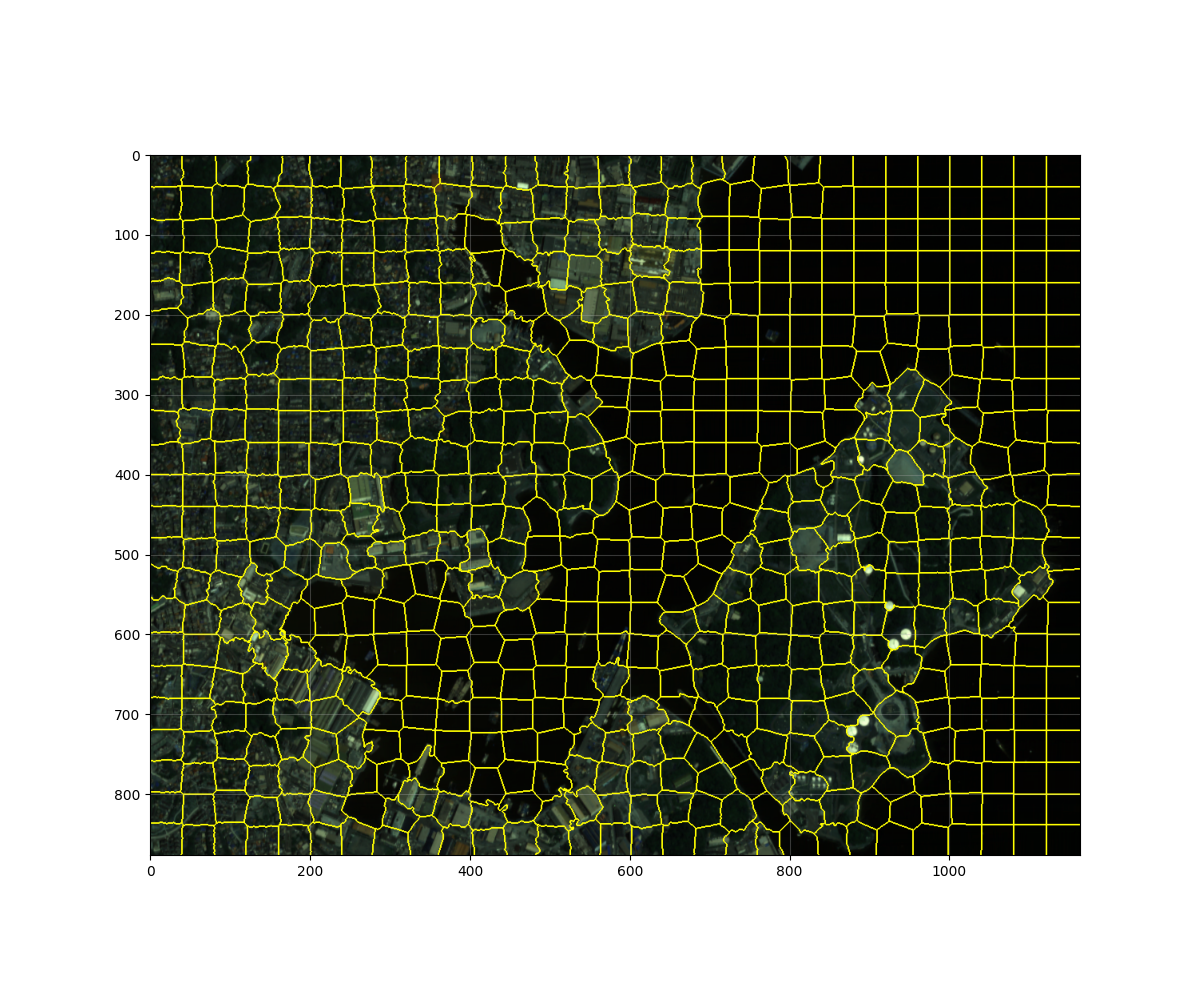

In [8]:
# plot_layer_interactive
%matplotlib widget
plot_layer_interactive(segmentation_layer,image_data=image_data)

In [9]:
# Samples for all eight different classes
samples={
"cropland": [11,396,489,1400,3818,1532,1470,810,594,1224,1388,13],
"meadow": [376,1040,44,2229,1099,514,65,3533,983,807],
"road": [1814,722,3303,552,2870],
"water": [3219,2005,3059,2483,4360,3108,2982,3090],
"buildings": [1937,1954,1730,2622,1912,1478,2026,1803,1864,1836],
"non_vegetated_space": [1122,1306,1872,1599,2297,1492,4027,3123,2343,2589,1235,1775,461,178,1785,2511,3250,3045,4543,1082,3812],
"deciduous": [516,1524,390,404,70],
"coniferous": [2874,558,1159,723,1773,136,235] 
}

classes_color= {
    "cropland": "#000000",
    "meadow":"#ffffff"
}

params={"n_estimators":100, "oob_score":True, "random_state":42}
RF_classification=SupervisedClassifier(name="RF Classification", classifier_type="Random Forest", classifier_params=params)
RF_classification_layer=RF_classification.execute(segmentation_layer,samples=samples,layer_manager=manager,layer_name="RF Classification",)


OOB Score: 0.21052631578947367


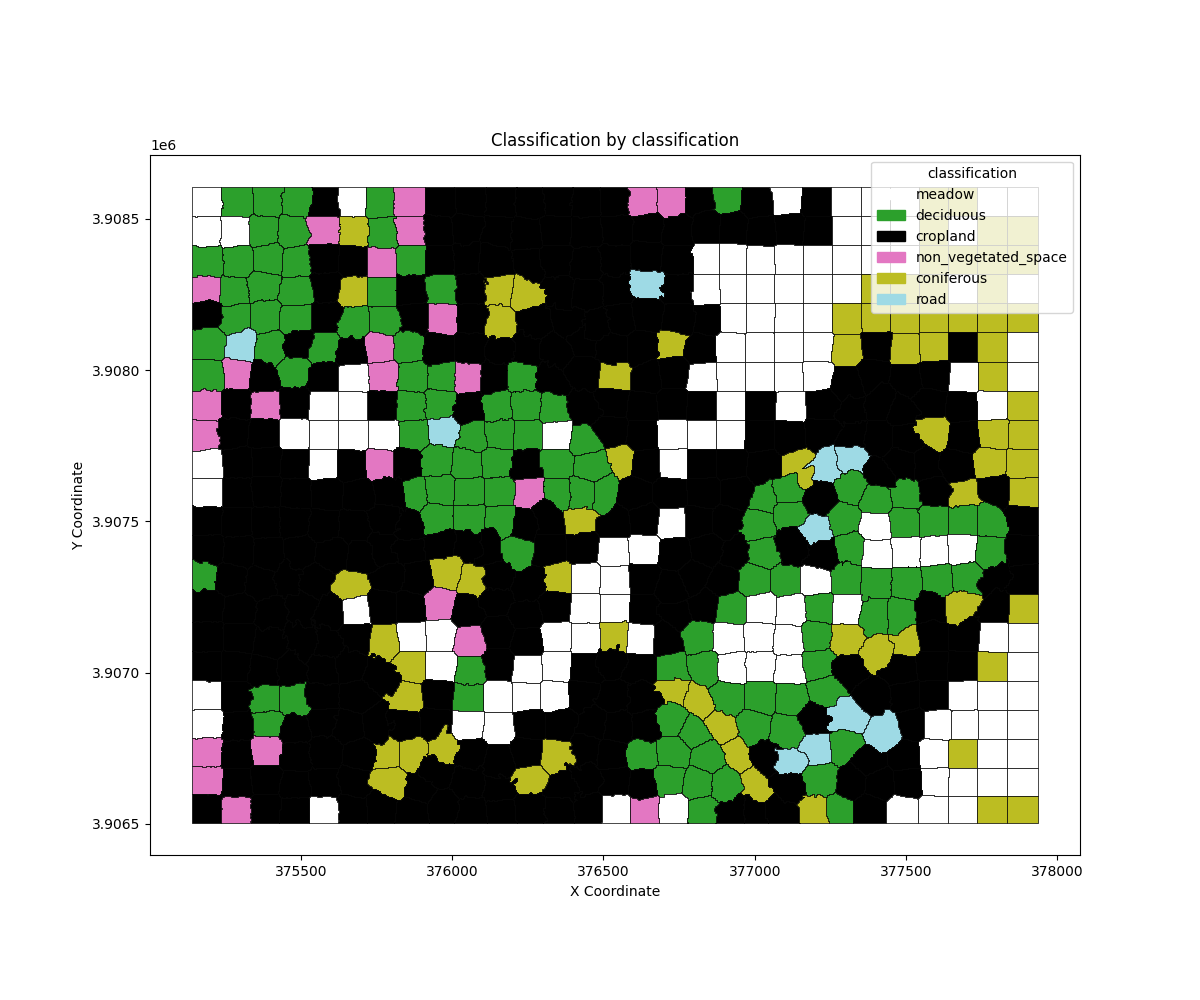

In [10]:

fig4 = plot_classification(RF_classification_layer, class_field="classification", class_color=classes_color)

plt.show()

In [11]:
RF_classification_layer.objects

segment_id  area_pixels  area_units  \
0             1         1650     9504.00   
1             2         1728     9953.28   
2             3         1614     9296.64   
3             4         1616     9308.16   
4             5         1506     8674.56   
..          ...          ...         ...   
630         631         1558     8974.08   
631         632         1596     9192.96   
632         633         1429     8231.04   
633         634         1451     8357.76   
634         635         1298     7476.48   

                                              geometry  band_1_mean  \
0    POLYGON ((375141.6 3908606.4, 375141.6 3908508...    43.919394   
1    POLYGON ((375237.6 3908606.4, 375237.6 3908560...    34.357060   
2    POLYGON ((375338.4 3908606.4, 375338.4 3908584...    37.953532   
3    POLYGON ((375444 3908606.4, 375444 3908587.2, ...    35.550743   
4    POLYGON ((375535.2 3908606.4, 375535.2 3908604...    45.048473   
..                                                 ...          ...   
630  POLYGON ((377736 3906592.8, 377736 3906501.6, ...    29.181643   
631  POLYGON ((377834.4 3906592.8, 377834.4 3906501...    29.167293   
632  POLYGON ((375504 3906590.4, 375504 3906588, 37...    47.783765   
633  POLYGON ((375837.6 3906590.4, 375837.6 3906585...    47.732598   
634  POLYGON ((376166.4 3906583.2, 376166.4 3906580...    53.819723   

     band_1_std  band_1_min  band_1_max  band_1_median  band_2_mean  ...  \
0      8.140370        31.0        86.0           42.0    58.730909  ...   
1      3.345524        30.0        64.0           34.0    46.379051  ...   
2      6.312569        30.0        77.0           35.0    52.075589  ...   
3      3.844103        30.0        68.0           34.0    49.555693  ...   
4      9.112965        29.0        86.0           43.0    61.469456  ...   
..          ...         ...         ...            ...          ...  ...   
630    0.387211        29.0        31.0           29.0    31.898588  ...   
631    0.381539        29.0        31.0           29.0    31.518170  ...   
632    7.937130        35.0        92.0           46.0    65.368789  ...   
633    9.025664        32.0        82.0           47.0    67.744314  ...   
634   11.056230        35.0        94.0           51.0    76.277350  ...   

     band_4_mean  band_4_std  band_4_min  band_4_max  band_4_median      NDVI  \
0      58.537576   15.826333        24.0       123.0           58.0  0.251516   
1      82.378472   19.910571        28.0       142.0           82.0  0.565249   
2      63.352540   18.600283        21.0       129.0           61.0  0.366508   
3      89.944926   21.759687        30.0       138.0           93.0  0.548552   
4      57.347942   17.604963        17.0       115.0           56.0  0.204496   
..           ...         ...         ...         ...            ...       ...   
630     6.700899    0.524508         6.0         8.0            7.0 -0.249623   
631     6.664787    0.531973         6.0         8.0            7.0 -0.252048   
632    50.392582   13.334811        19.0       109.0           50.0  0.096300   
633    55.165403   22.844880        12.0       130.0           50.0  0.122572   
634    56.162558   12.056132        30.0       114.0           53.0  0.062567   

     perimeter  shape_index  compactness  classification  
0        412.8     1.194487     0.700869          meadow  
1        432.0     1.221506     0.670206       deciduous  
2        436.8     1.277952     0.612309       deciduous  
3        446.4     1.305231     0.586983       deciduous  
4        432.0     1.308444     0.584104        cropland  
..         ...          ...          ...             ...  
630      379.2     1.129194     0.784266      coniferous  
631      384.0     1.129792     0.783435      coniferous  
632      388.8     1.208910     0.684246        cropland  
633      417.6     1.288578     0.602253        cropland  
634      388.8     1.268448     0.621519        cropland  

[635 rows x 29 columns]